In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# !pip install ultralytics
# !pip install accelerate

In [3]:
import torch

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [5]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [6]:
from transformers import ViTForImageClassification

model_clf = ViTForImageClassification.from_pretrained(
    '/content/drive/MyDrive/ml2/ML_project_2_course/weights/'
)

In [8]:
model_clf

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

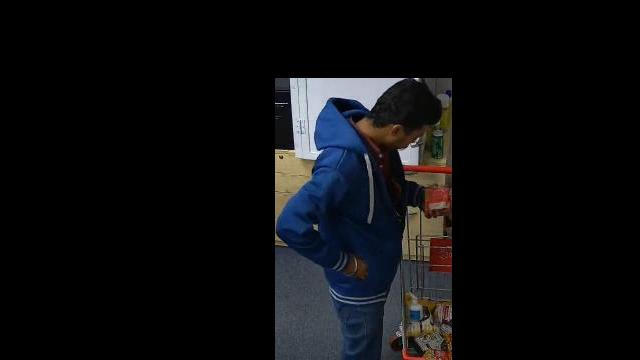

In [9]:
from PIL import Image

im = Image.open('/content/drive/MyDrive/ml2/ML_project_2_course/datasets/Dataset_CSV/Train_composed/0.jpg')
im

In [11]:
inputs = processor(im, return_tensors='pt')

inputs

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [ ]:
logits = model_clf(inputs['pixel_values'].to(device)).logits

logits

In [1]:
from google.colab.patches import cv2_imshow

In [2]:
import cv2
from ultralytics import YOLO
import random


def draw_bounding_boxes_without_id(frame, results):
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    classes = results[0].boxes.cls.cpu().numpy().astype(int)

    for box, clss in zip(boxes, classes):
        # Generate a random color for each object based on its ID
        if clss != 0:
            random.seed(int(clss)+8)
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3],), color, 2)
            cv2.putText(
                frame,
                f"{model.model.names[clss]}",
                (box[0], box[1]),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (50, 255, 50),
                2,
            )
    return frame


def process_video_with_tracking(model, input_video_path, show_video=True, save_video=False, output_video_path="output_video.mp4"):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")

    # Get input video frame rate and dimensions
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the output video writer
    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        results = model.track(frame, iou=0.4, conf=0.3, persist=True, imgsz=608, verbose=False, tracker="bytetrack.yaml", classes=0)

        if results[0].boxes.id != None: # this will ensure that id is not None -> exist tracks
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):
                # Generate a random color for each object based on its ID
                random.seed(int(id))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3],), color, 2)
                cv2.putText(
                    frame,
                    f"Id {id}",
                    (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.70,
                    (0, 255, 255),
                    2,
                )

        if save_video:
            out.write(frame)

        if show_video:
            frame = cv2.resize(frame, (0, 0), fx=0.75, fy=0.75)
            # cv2.imshow("frame", frame)
            cv2_imshow(frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # Release the input video capture and output video writer
    cap.release()
    if save_video:
        out.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()
    return results

# Example usage:
model = YOLO('yolov8m.pt')
model.fuse()
results = process_video_with_tracking(model, "/content/drive/MyDrive/ml2/ML_project_2_course/datasets/videos/Shoplifting042_x264.mp4", show_video=False, save_video=True, output_video_path="/content/drive/MyDrive/ml2/ML_project_2_course/datasets/videos_tracked/output_video1.mp4")

YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs
